In [2]:
!pip install pingouin


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=b1fb03892c4e28b03766e6a6846473233767268079f248827b70c59600c9c98c
  Stored in directory: /root/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from collections import Counter
sns.set_style('whitegrid')
pd.options.mode.chained_assignment = None # default='warn'

We can study our dataset by checking for existing columns.

In [4]:
complete_protest = pd.read_csv("GlobalProtestTracker.csv")
# Check for general information
complete_protest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Country                                   329 non-null    object
 1   Protest Name                              329 non-null    object
 2   Start Date                                329 non-null    object
 3   Freedom Rating (Status)                   329 non-null    object
 4   Triggers                                  329 non-null    object
 5   Motivations                               329 non-null    object
 6   Peak Size                                 329 non-null    object
 7   Key Participants                          328 non-null    object
 8   Duration                                  329 non-null    object
 9   Outcomes                                  328 non-null    object
 10  Active protests                           17 non-n

In [5]:
hum_freedom_complete = pd.read_csv("Aggregate_Category_and_Subcategory_Scores_FIW_2006-2022.csv")
hum_freedom_complete.info()
hum_freedom_complete.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3549 entries, 0 to 3548
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country/Territory  3549 non-null   object 
 1   Region             3549 non-null   object 
 2   C/T?               3549 non-null   object 
 3   Edition            3549 non-null   int64  
 4   Status             3549 non-null   object 
 5   PR Rating          3549 non-null   int64  
 6   CL Rating          3549 non-null   int64  
 7   A                  3549 non-null   int64  
 8   B                  3549 non-null   int64  
 9   C                  3549 non-null   int64  
 10  Add Q              3549 non-null   int64  
 11  Add A              2501 non-null   float64
 12  PR                 3549 non-null   int64  
 13  D                  3549 non-null   int64  
 14  E                  3549 non-null   int64  
 15  F                  3549 non-null   int64  
 16  G                  3549 

Index(['Country/Territory', 'Region', 'C/T?', 'Edition', 'Status', 'PR Rating',
       'CL Rating', 'A', 'B', 'C', 'Add Q', 'Add A', 'PR', 'D', 'E', 'F', 'G',
       'CL', 'Total', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29',
       'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'x'],
      dtype='object')

Select he columns for following analysis

In [6]:
protest = complete_protest.iloc[:, [0 , 1, 2, 3, 6, 7, 8, 10, 
                                    11, 12, 13, 14, 15, 16, 17, 18, 19]]
hum_freedom = hum_freedom_complete.iloc[:, [0, 3, 12, 17, 18]]
protest.info()
hum_freedom.info()                                    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Country                                   329 non-null    object
 1   Protest Name                              329 non-null    object
 2   Start Date                                329 non-null    object
 3   Freedom Rating (Status)                   329 non-null    object
 4   Peak Size                                 329 non-null    object
 5   Key Participants                          328 non-null    object
 6   Duration                                  329 non-null    object
 7   Active protests                           17 non-null     object
 8   Economic motivation?                      117 non-null    object
 9   Political motivation?                     286 non-null    object
 10  Corruption motivation?                    66 non-n

Adjust some columns names for the sake of clarity

In [7]:
# Make some alterationd in hum_freedom table brfore using it
hum_freedom = hum_freedom.rename(columns={'Edition':'Year', 'PR':'Pltc_rights_scr',
                                          'CL':'Cvl_rights_scr', 'Total':'Total_scr',})
hum_freedom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3549 entries, 0 to 3548
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Country/Territory  3549 non-null   object
 1   Year               3549 non-null   int64 
 2   Pltc_rights_scr    3549 non-null   int64 
 3   Cvl_rights_scr     3549 non-null   int64 
 4   Total_scr          3549 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 138.8+ KB


Correct columns with country names to meet the consistancy requirement

In [8]:
# Setting for consistancy withon country names colimn
print(protest['Country'].nunique())
protest['Country'] = protest['Country'].str.title()
print(protest['Country'].nunique())

print(hum_freedom['Country/Territory'].nunique())
hum_freedom['Country/Territory'] = hum_freedom['Country/Territory'].str.title()
print(hum_freedom['Country/Territory'].nunique())

126
125
218
218


Check for duplicate values creating unique keys for each table. We see that unique keys equal to number of rows in each table.

In [9]:
# Check for duplicate values
print(protest.groupby(['Country', 'Protest Name', 'Start Date']).ngroups)

print(hum_freedom.groupby(['Country/Territory', 'Year']).ngroups)

329
3549


Check for typos and misprints among categories names in categorical values. Then make corrections.

In [10]:
# Check for incorrect values in columns with category values
print(protest['Freedom Rating (Status)'].unique())
print(protest['Size category'].unique())

['Free' 'Partly free' 'Not free' 'Partly freee']
['Thousands' 'Tens of thousands' 'Hundreds of thousands' 'Over 1 million'
 'Hundreds' 'Millions' 'Hundreds of of thousands' 'Unknown'
 'Huundreds of thousands' 'Tens of millions' 'Thosuands']


In [11]:
# Replace incorrect values in Freedom Rating (Status) column
protest['Freedom Rating (Status)'] = protest['Freedom Rating (Status)'].replace('Partly freee',
                                                                                'Partly free')
print(protest['Freedom Rating (Status)'].unique())

['Free' 'Partly free' 'Not free']


In [12]:
# Replace incorrect values in Size category column and changing category format
protest['Size category'] = protest['Size category'].replace(['Thousands', 'Thosuands','Tens of thousands',
                                                             'Hundreds of thousands','Hundreds of of thousands',
        'Huundreds of thousands', 'Over 1 million', 'Millions', 'Tens of millions', 'Hundreds'],
        ['K1-10','K1-10', 'K10-100', 'K100-KK1', 'K100-KK1', 'K100-KK1', 'KK1-10', 'KK1-10',
                                                                    'KK10-100', '100-1000'])
print(protest['Size category'].unique())

['K1-10' 'K10-100' 'K100-KK1' 'KK1-10' '100-1000' 'Unknown' 'KK10-100']


Check for null values. ('False' and 'X' means True)

Substitute NULL values with '0' and 'X' values with 1.

In [13]:
# Check for null values
print(protest.isnull().sum())

Country                                       0
Protest Name                                  0
Start Date                                    0
Freedom Rating (Status)                       0
Peak Size                                     0
Key Participants                              1
Duration                                      0
Active protests                             312
Economic motivation?                        212
Political motivation?                        43
Corruption motivation?                      263
Size category                                 0
Protests with a significant outcome         230
Large protests (Over 100,000 protesting)    279
Violent government response                 239
Long protests (more than 3 months)          249
Coronavirus-related protests                281
dtype: int64


In [14]:
# In columns with boolean values replace 'NaN' values to 0 and 'X' values to 1
protest = protest.fillna({'Active protests':0, 'Economic motivation?':0, 'Political motivation?':0,
                'Corruption motivation?':0, 'Protests with a significant outcome':0,
                'Large protests (Over 100,000 protesting)':0, 'Violent government response':0,
                'Long protests (more than 3 months)':0, 'Coronavirus-related protests':0})
protest = protest.replace({'X':1})
protest['Key Participants'] = protest['Key Participants'].fillna('Unknown')
print(protest.isna().sum())

Country                                     0
Protest Name                                0
Start Date                                  0
Freedom Rating (Status)                     0
Peak Size                                   0
Key Participants                            0
Duration                                    0
Active protests                             0
Economic motivation?                        0
Political motivation?                       0
Corruption motivation?                      0
Size category                               0
Protests with a significant outcome         0
Large protests (Over 100,000 protesting)    0
Violent government response                 0
Long protests (more than 3 months)          0
Coronavirus-related protests                0
dtype: int64


We adjust data type in 'Start Date' column to 'datetime' and create two additional columns with month and year where protest started.

In [15]:
# Change 'Start Date' to 'datetime'
protest['Start Date'] = pd.to_datetime(protest['Start Date'], 
                                       format='%b-%y', exact=False)
protest['Year'] = protest['Start Date'].dt.year
protest['Month'] = protest['Start Date'].dt.month

Shorten column names to using the principles of effective naming.

In [16]:
# SHorten column names for convinience
protest = protest.rename(columns={'Protest Name':'Prtst_name', 'Start Date':'Strt_date',
                               'Freedom Rating (Status)':'Frdm_status', 'Peak Size': 'Peak_size',
                               'Key Participants':'Participants', 'Active protests':'Active',
                               'Economic motivation?':'Ecnm_motive', 'Political motivation?':
                                'Pltc_motive', 'Corruption motivation?':'Corr_motive',
                               'Size category':'Size_category', 'Protests with a significant outcome':
                               'Sig_outcome', 'Large protests (Over 100,000 protesting)':'Large_prtst',
                               'Violent government response':'Viol_gov_respns','Long protests (more than 3 months)':'Long_prtst',
                                'Coronavirus-related protests':'Covid_prtst'})
protest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Country          329 non-null    object        
 1   Prtst_name       329 non-null    object        
 2   Strt_date        329 non-null    datetime64[ns]
 3   Frdm_status      329 non-null    object        
 4   Peak_size        329 non-null    object        
 5   Participants     329 non-null    object        
 6   Duration         329 non-null    object        
 7   Active           329 non-null    int64         
 8   Ecnm_motive      329 non-null    int64         
 9   Pltc_motive      329 non-null    int64         
 10  Corr_motive      329 non-null    int64         
 11  Size_category    329 non-null    object        
 12  Sig_outcome      329 non-null    int64         
 13  Large_prtst      329 non-null    int64         
 14  Viol_gov_respns  329 non-null    int64    

Add new column names with translation process duration text values into numeric values.

In [17]:
# Adding a new column with approximate protest duration in days
dur_val = protest['Duration'].value_counts()
print(protest['Duration'].value_counts())
protest['Duration_str'] = protest['Duration']
replaced = []
for i, v in dur_val.iteritems():
  replaced.append(i)

replacing = [1, 7, 30, 60, -1, 14, 120, 150, 90, 21, 14*30,
             240, 365, 180, 3, 10, 365, 2, 365+180, 330,
             365+120, 15*30, 300, 16*30, 365, 210, 365*2,
             22, 8, 28, 365+60, 270, 42, 210, 15*30, 141,
             210, 5, 365+60,365+240, 365+150, 365+270, 
             -1, 210, 13*30,270,365+90]
protest['Duration'] = protest['Duration'].replace(replaced, replacing)

1 day                                                    57
1 week                                                   50
1 month                                                  44
2 months                                                 32
Active                                                   16
2 weeks                                                  15
4 months                                                 15
5 months                                                 11
3 months                                                 10
3 weeks                                                   9
14 months                                                 6
8 months                                                  5
1 year                                                    4
6 months                                                  4
3 days                                                    4
10 days                                                   3
1 year, intermittently                  

Join the two datasets

In [18]:
protest_for_model = protest.merge(hum_freedom, left_on=['Country', 'Year'],
                                  right_on=['Country/Territory', 'Year'],
                                  how= 'left')
del protest_for_model['Country/Territory']
protest_for_model.info()
protest_for_model= protest_for_model.dropna()
protest_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 0 to 328
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Country          329 non-null    object        
 1   Prtst_name       329 non-null    object        
 2   Strt_date        329 non-null    datetime64[ns]
 3   Frdm_status      329 non-null    object        
 4   Peak_size        329 non-null    object        
 5   Participants     329 non-null    object        
 6   Duration         329 non-null    int64         
 7   Active           329 non-null    int64         
 8   Ecnm_motive      329 non-null    int64         
 9   Pltc_motive      329 non-null    int64         
 10  Corr_motive      329 non-null    int64         
 11  Size_category    329 non-null    object        
 12  Sig_outcome      329 non-null    int64         
 13  Large_prtst      329 non-null    int64         
 14  Viol_gov_respns  329 non-null    int64    

Analysis

**Countries with the most protest**

Calculate the total number of protest that have occured during observational periods in each country.
From the list of all of the countries return the top 10, by highest number of protest.

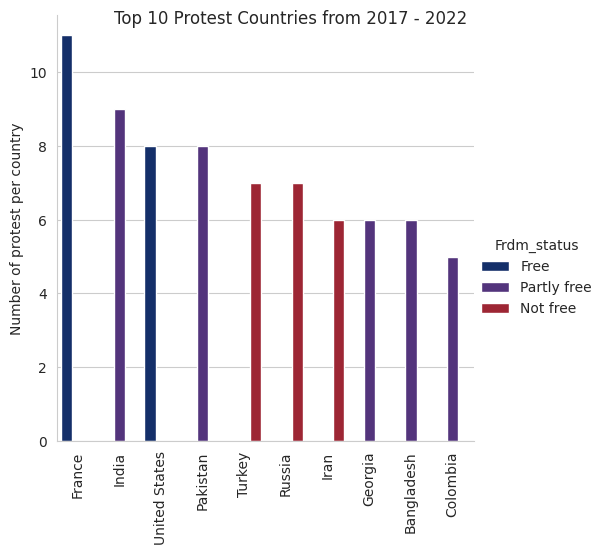

In [19]:
# Create dataset with number of protest grouped by country
protest_per_country = protest.groupby(['Country', 'Frdm_status']).agg({'Prtst_name':'count'})
protest_per_country = protest_per_country.reset_index()
protest_per_country = protest_per_country.rename(columns={'Prtst_name': 'Total_protests'})
protest_per_country = protest_per_country.sort_values('Total_protests', ascending=False)

# Define top 10 protest countries
top10_prtst_cntr = protest_per_country.head(10)

# Plot
sns.set_palette(['#062A77', '#512888', '#B11225'])
g = sns.catplot(kind='bar', data=top10_prtst_cntr,
                x='Country', y='Total_protests', 
                hue='Frdm_status')
g.fig.suptitle('Top 10 Protest Countries from 2017 - 2022')
g.set(xlabel='', ylabel='Number of protest per country')
plt.xticks(rotation=90)
plt.show()

Finding show:
Countries with all kind of Freedom Status(Free, Partly Free, Not Free).
The most protestant country would be France where the duration during observation periods occured 11 protest.

**Freedom vs. Protest Activity**

*Avg. number of protest*

We have not seen any sort of association from  the top 10 protest countries plot.

Define if a countrys freedom status influences protest activity within the country.

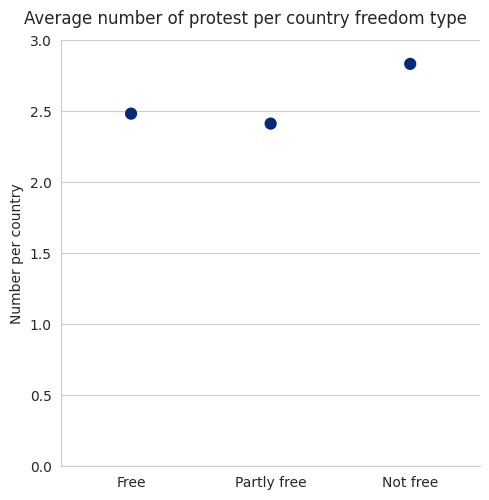

In [20]:
frdm_prtst = protest.groupby('Frdm_status').agg({'Prtst_name':'count'})
free_countries = (protest[protest['Frdm_status'] == 'Free'])['Country'].nunique()
p_free_countries = (protest[protest['Frdm_status'] == 'Partly free'])['Country'].nunique()
n_free_countries = (protest[protest['Frdm_status'] == 'Not free'])['Country'].nunique()
per_status = [free_countries, n_free_countries, p_free_countries]
frdm_prtst['Avg_per_country'] = (frdm_prtst['Prtst_name'] / per_status).round(2)
frdm_prtst = frdm_prtst.reset_index()

# Dot Plot
g = sns.catplot(kind='point', data= frdm_prtst,
                x = 'Frdm_status', y = 'Avg_per_country',
                order = ['Free', 'Partly free', 'Not free'],
                join = False)
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
g.set(xlabel = '', ylabel ='Number per country')
g.fig.suptitle('Average number of protest per country freedom type',
               y = 1.03)
plt.show()


We've found that protest occur slighty more in 'Not free' counties than 'Partly free' or 'free' countries.

*Protest Duration*

Build some Boxplot to check if there is any difference between durations in different country types. Active protest excluded.

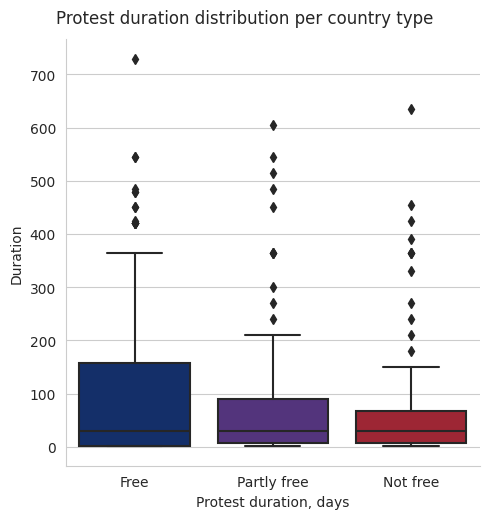

In [21]:
# Box plot
n = sns.catplot(x='Frdm_status', y='Duration', kind='box', data=protest[protest['Active'] == 0],
                order = ['Free', 'Partly free', 'Not free'])
n.set(xlabel='Protest duration, days')
n.fig.suptitle("Protest duration distribution per country type", y= 1.03)
plt.show()

We've found that the median duration is very similar in countries with any freedom state, but the duration of protest had more variation in countries with BETTER freedom status.

*Protest Size*
Unfortunately, we do not have the exact number of protestants. For evaluation of size variable build bars calculating protest within every group size for each country.

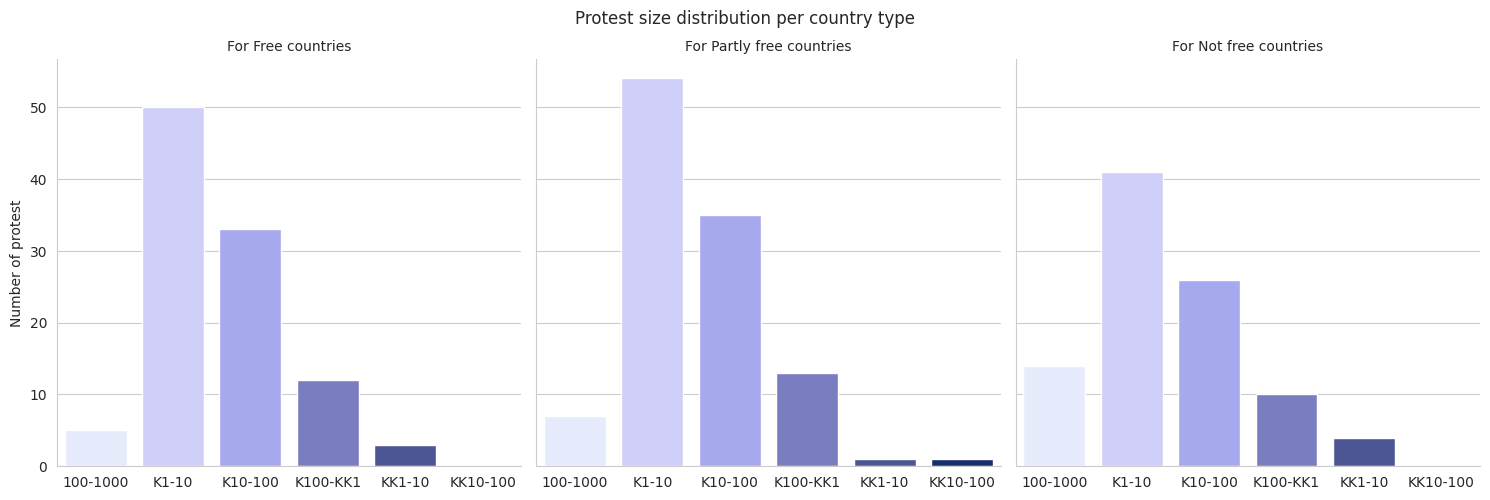

In [22]:
# Box Plot
pal = ['#e4eaff', '#C8C8FF', '#9B9DFB', '#6E74CD', '#414DA1', '#062A77']
n = sns.catplot(kind = 'count', data=protest[protest['Active'] == 0],
                x = 'Size_category', col='Frdm_status', 
                col_order=['Free', 'Partly free', 'Not free'],
                palette=pal, order=['100-1000','K1-10', 'K10-100', 
                                   'K100-KK1', 'KK1-10', 'KK10-100'])
n.set(xlabel='', ylabel='Number of protest')
n.fig.suptitle('Protest size distribution per country type', y= 1.03)
n.set_titles('For {col_name} countries')
plt.show()

Protest group size are similarly distributed in all country types.

There is a right-skewed distribution with a peak at K1-10 group.

Most of the protest attract from 1000 to 10,000 protestants.

*Main protest motives*

We found some difference in protest attributes between countries with different level of freedom. Now we will analyze what causes protest activity.

Consider 3 main triggers:


*   Econimics
*   Politics
*   Corruption

Combining these triggers all protest will be split into 7 groups:



1.   **E -** pure economics motivation 
2.   **P -** pure politics motivation
3.   **C -** pure corruption motivation
4.   **EP -** both economics/politics motivation
5.   **EC -** both economics/corruption motivation 
6.   **PC -** both politics/ corruption motivation
7.   **EPC -** moxed economics/politics/corruption motivation

We will study distribution protest among groups and between countries










P        173
EP        58
PC        33
E         28
EPC       22
EC         9
Other      4
C          2
Name: Motivation_group, dtype: int64


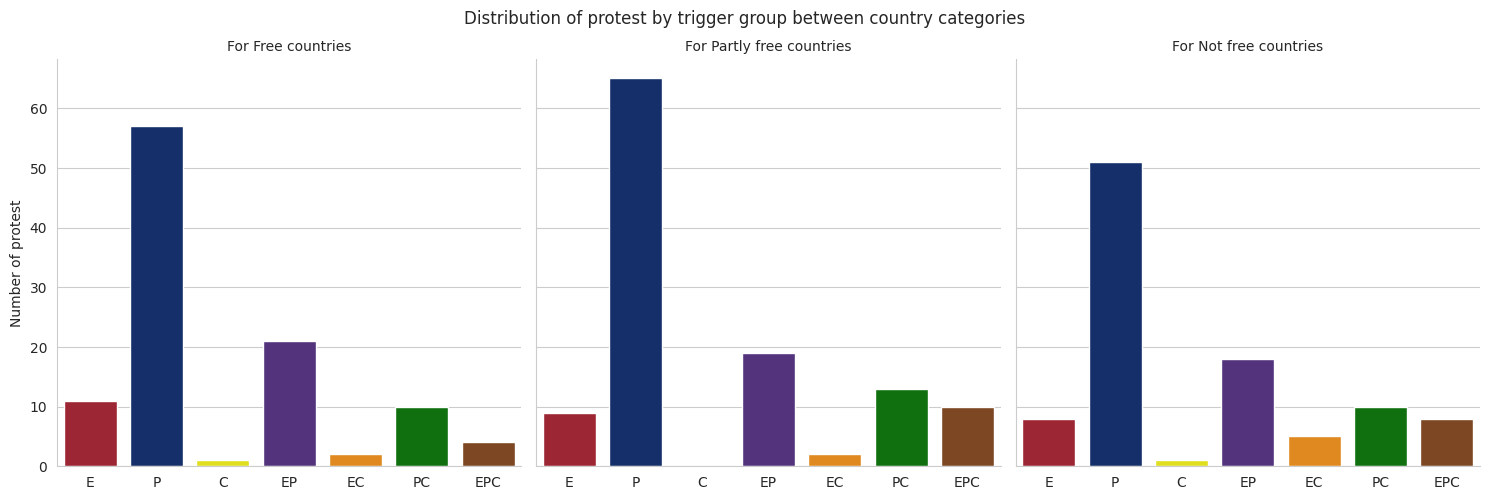

In [23]:
# Define main protest motive
condition = [(protest['Ecnm_motive']==1)&(protest['Pltc_motive']==0)&
             (protest['Corr_motive']==0),
    (protest['Ecnm_motive']==0)&(protest['Pltc_motive']==1)&
        (protest['Corr_motive']==0),
    (protest['Ecnm_motive']==0)&(protest['Pltc_motive']==0)&
        (protest['Corr_motive']==1),
    (protest['Ecnm_motive'] == 1) & (protest['Pltc_motive'] == 1)&
        (protest['Corr_motive'] == 0),
    (protest['Ecnm_motive'] == 1) & (protest['Pltc_motive'] == 0)&
        (protest['Corr_motive'] == 1),
    (protest['Ecnm_motive'] == 0) & (protest['Pltc_motive'] == 1)&
        (protest['Corr_motive'] == 1),
    (protest['Ecnm_motive'] == 1) & (protest['Pltc_motive'] == 1)&
    (protest['Corr_motive'] == 1)]

group = ['E','P','C','EP','EC','PC','EPC']
protest['Motivation_group'] = np.select(condition, group, default='Other')
print(protest['Motivation_group'].value_counts())

# Bar Plot
g = sns.catplot(kind='count', data=protest, x='Motivation_group', col='Frdm_status',
                order=['E','P','C','EP','EC','PC','EPC'], palette={'E':'#B11225', 'P':'#062A77', 'C' : 'yellow', 'EP':'#512888', 
                                                                        'EC':'darkorange', 'PC':'green', 'EPC':'saddlebrown'})
g.fig.suptitle('Distribution of protest by trigger group between country categories',
               y=1.03)
g.set(xlabel='', ylabel='Number of protest')
g.set_titles('For {col_name} countries')
plt.show()

We've found that **Politics is the most effective trigger**. **Top 3** most populated trigger groups are **pure Politics, and Politics variation with other triggers**. **Distribution** in countries with **different levels of freedom** was similar and **did not show significant distinctions** and in general, repeated tendencies of the complex distribution.

***Government Response***

*Top Counties responded violently*

We will find the top countries that had violent responses with a higher than average rate. By Countru and Freedom Status: calculate share of violent responses, filter the results for values higher than average rate violent response and order by absolute value of violent responded protest and share.

In [24]:
# Defines if free countries have less tendancy to use violence against protestants
cntry_viol = protest.groupby(['Country', 'Frdm_status']).agg({'Viol_gov_respns':'sum'})
tend_to_viol = protest_per_country.merge(cntry_viol, on=['Country','Frdm_status'])
tend_to_viol['Violence_share'] = ((tend_to_viol['Viol_gov_respns'] / tend_to_viol['Total_protests'])*100).round()
mean_viol_resp = (protest['Viol_gov_respns'].mean()*100).round(2)
high_viol = tend_to_viol[tend_to_viol['Violence_share'] > mean_viol_resp]
high_viol = high_viol.sort_values(['Viol_gov_respns','Violence_share'], ascending=False)
print(high_viol.head(20))


         Country  Frdm_status  Total_protests  Viol_gov_respns  Violence_share
22      Eswatini     Not free               4                4           100.0
24        Uganda     Not free               4                3            75.0
30       Belarus     Not free               4                3            75.0
10         Spain         Free               5                3            60.0
5         Russia     Not free               7                3            43.0
3       Pakistan  Partly free               8                3            38.0
56         Niger  Partly free               2                2           100.0
57       Nigeria  Partly free               2                2           100.0
69         Egypt     Not free               2                2           100.0
70       Croatia         Free               2                2           100.0
31      Zimbabwe     Not free               3                2            67.0
40          Chad     Not free               3       

Top-3 countries in the list and **five countries** in total from the list are considered **Not free, three countries** are **Partly free and two are Free countries.**

*Violence by freedom status*

There's some difference in the average number of protest between countries with different levels of freedom.

How do countries from different groups respond to the protest?
Calculate share of protest that provoked violent government responses for countries in each freedom group.

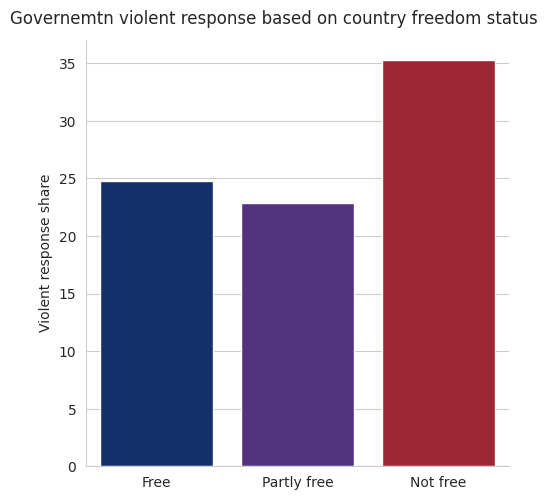

In [25]:
# Calculate share of governemtn violent response to protest pending on freedom status
frdm_vlnc_tend = protest[protest['Viol_gov_respns'] == 1]
frdm_vlnc_tend = frdm_vlnc_tend.groupby('Frdm_status').agg({'Viol_gov_respns':'count'}).reset_index()
frdm_vlnc_tend['Share_of_total'] = ((frdm_vlnc_tend['Viol_gov_respns']/ (frdm_prtst['Prtst_name'])*100).round(2))

# Plot
sns.set_palette(['#062A77', '#512888', '#B11225'])
g=sns.catplot(x='Frdm_status', y='Share_of_total', kind='bar', data=frdm_vlnc_tend, order=[
    'Free', 'Partly free', 'Not free'])
g.set(xlabel='', ylabel='Violent response share')
g.fig.suptitle('Governemtn violent response based on country freedom status', y= 1.03)
plt.show()

The results show that Not free countries more frequently responded violently top protest other than countries with higher freedom rating.

Perform Chi2 test with 5% significance level to confirm if the share of violence is dependant on the countries freedom status.

In [26]:
# Chi2 test
expected, observed, stats = pg.chi2_independence(data=protest, 
                                                 x='Frdm_status', y='Viol_gov_respns',
                                                 correction=False)
print(stats)

                 test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  4.789883  2.0  0.091178  0.120660  0.485723
1        cressie-read  0.666667  4.748681  2.0  0.093076  0.120140  0.482165
2      log-likelihood  0.000000  4.677376  2.0  0.096454  0.119235  0.475976
3       freeman-tukey -0.500000  4.633132  2.0  0.098612  0.118670  0.472118
4  mod-log-likelihood -1.000000  4.596403  2.0  0.100439  0.118198  0.468904
5              neyman -2.000000  4.544249  2.0  0.103093  0.117526  0.464323


p-value is 0.091178 that is higher that 0.05. So **we can not state with 5% significance that violent governemt response is dependant on freedom status.**

*Violence and protest*
Probably constant and sustainable protest tempt a government to use violence to top the protest.

Check if there is a significant difference in duration between the protest that faced governement violence and those that did not

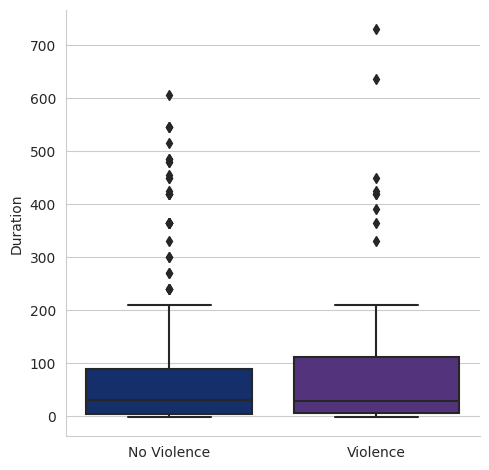

In [27]:
# Box plot that pictured distribution of protest duration between two groups
g = sns.catplot(kind='box', data=protest, x='Viol_gov_respns', y='Duration')
g.set(xlabel='')
plt.xticks([0,1],['No Violence', 'Violence'])
plt.show()

The boxplot findings show that the protest that faced violent response from government have higher variation in duration.

*Violent response correlation*

Look more precisely at the violent government response and other variables that it can be related to:



*   **Total_scr** - total scores vale recieved by country in Freedom rating
*   **Duration** - protest duration in days
*   **Size_score** - customized column that assign score to a protest according to value from Size_category column. Values are from 1 for the smallest category '100-1000' to 6 for the largest category 'KK10-100'
*   **Lag_prtst** - the column that assigns value of 1 for all protest with more that 100,000 protestants
*   **Long_prtst** - the column that asssigns value of 1 for all protest that lasted longer that 3 months

Mentioned columns will be selected for creating a correlation table:




                 Viol_gov_respns  Duration  Size_scr  Long_prtst  Large_prtst
Viol_gov_respns         1.000000  0.003472 -0.028862    0.153853     0.098648
Duration                0.003472  1.000000  0.095361    0.176278     0.114571
Size_scr               -0.028862  0.095361  1.000000    0.114952     0.126005
Long_prtst              0.153853  0.176278  0.114952    1.000000     0.385617
Large_prtst             0.098648  0.114571  0.126005    0.385617     1.000000


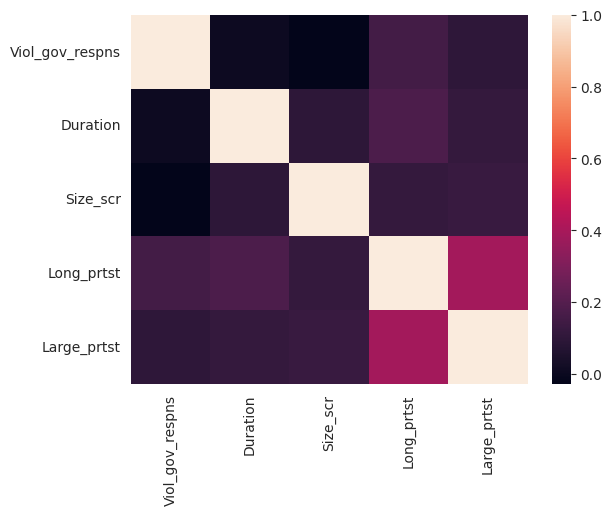

In [28]:
# Creating Size_scr column
size_p = []
for s in protest_for_model['Size_category']:
  if s == '100-1000': size_p.append(1)
  elif 'K1-10': size_p.append(2)
  elif 'K10-100': size_p.append(3)
  elif 'K100-KK1':size_p.append(4)
  elif 'KK1-10': size_p.append(5)
  elif 'KK10-100': size_p.append(6)
  else: size_p.append(0)
protest_for_model['Size_scr'] = size_p
viol_corr = protest_for_model[['Viol_gov_respns', 'Duration', 'Size_category',
                               'Size_scr', 'Long_prtst', 'Large_prtst']].corr()
print(viol_corr)
g = sns.heatmap(viol_corr)
plt.show()                               


We found 0.15 positive correlation with Long_prtst and 0.09 with Large_prtst variablr, however no significant relation with Duration ans Size_scr. We can conclude that **government have a little bit higher tendency towards a violent response to the protest that last more than 3 months and involve more than 100,000 protestants.**

**Protests with significant outcome**

After studying the protest activity in general and government responses to this, we will look closer to successful protests. Split the data by Sig_outcome variable. Look at mean values.

In [29]:
sig = protest_for_model[protest_for_model['Sig_outcome'] == 1]
print(sig[['Duration', 'Large_prtst', 'Viol_gov_respns', 'Long_prtst']].mean())
n_sig = protest_for_model[protest_for_model['Sig_outcome'] == 0]
print(n_sig[['Duration', 'Large_prtst', 'Viol_gov_respns', 'Long_prtst']].mean())

Duration           85.104167
Large_prtst         0.208333
Viol_gov_respns     0.302083
Long_prtst          0.312500
dtype: float64
Duration           88.120000
Large_prtst         0.128889
Viol_gov_respns     0.248889
Long_prtst          0.213333
dtype: float64


From the results we've found that **among the protests and the protests that failed there were differences in shares of large protest, long protest and government violent response.**

Check if these differences are statistically significant with hypothesis testing.

*Large protest share test*

HO: Proportion of large protest among these protest that achieved significant outcomes is the same as among protest that have not.
p1 - p0 = 0 H1: p1 - p0 > 0 alpha 0.05

In [30]:
print(n_sig['Large_prtst'].value_counts())
print(sig['Large_prtst'].value_counts())
success_counts = np.array([20,29])
n = np.array([96, 29+196])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative='larger')
print(p_value)

0    196
1     29
Name: Large_prtst, dtype: int64
0    76
1    20
Name: Large_prtst, dtype: int64
0.034992376610781036


The p-value is smaller than 0.05. **We can state with 95% confidence that the share of large protest is greater among the protests with significant results.**

*Long protest share test*

H0: Proportion of long protest among these protest that achieved significant outcomes is the same as among protest that have not. p1 - p0 = 0
H1: p1 - p0 > alpha 0.05

In [31]:
print(n_sig['Long_prtst'].value_counts())
print(sig['Long_prtst'].value_counts())
success_counts = np.array([30, 48])
n = np.array([96, 48+177])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, 
                                  alternative='larger')
print(p_value)


0    177
1     48
Name: Long_prtst, dtype: int64
0    66
1    30
Name: Long_prtst, dtype: int64
0.028934918190342846


The p-value is smaller than 0.05. **We can state with 95% confidence that the share of long protest is greater among the protests with significant results.**

*Violent response share test*

H0: Proportion of violent response protest among these protest that achieved significant outcomes is the same as among protest that have not. p1 - p0 = 0
H1: p1 - p0 > alpha 0.05

In [32]:
print(n_sig['Viol_gov_respns'].value_counts())
print(sig['Viol_gov_respns'].value_counts())
success_counts = np.array([29,56])
n = np.array([96,48+177])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative='larger')
print(p_value) 

0    169
1     56
Name: Viol_gov_respns, dtype: int64
0    67
1    29
Name: Viol_gov_respns, dtype: int64
0.1613405325363244


The p-value is significantly higher than 0.05. **We can't state with 95% and not even with 90% confidence that the share of government violent response differs between the protests with  and without significant results.**

*Significant outcome in countries from different freedom categories*

Now we will analyze if protest achieve more results in countries with more freedom. Calculate a share of succeeded protest for countries within each freedom category.

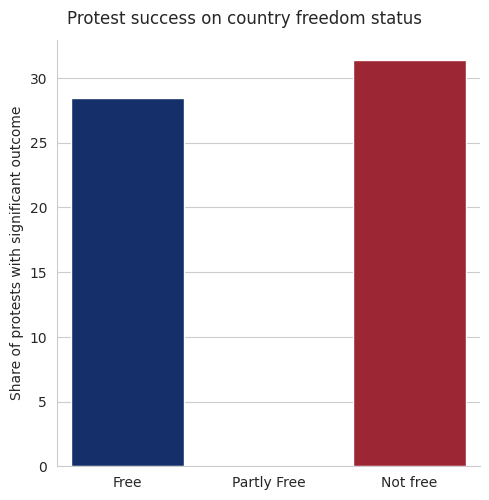

In [33]:
sig_prot = protest[protest['Sig_outcome'] == 1]
frdm_sig = sig_prot.groupby('Frdm_status').agg({'Sig_outcome':'count'}).reset_index()

frdm_sig['Sig_share'] = (frdm_sig['Sig_outcome']*100 /frdm_prtst['Prtst_name']).round(2)
frdm_sig['Insig_share'] = (100 - frdm_sig['Sig_share']).round(2)

# Plot
sns.set_palette(['#062A77', '#512888', '#B11225'])
g = sns.catplot(x='Frdm_status', y='Sig_share', kind='bar', data= frdm_sig,
                order=['Free', 'Partly Free', 'Not free'])
g.set(xlabel='', ylabel='Share of protests with significant outcome')
g.fig.suptitle('Protest success on country freedom status', y= 1.03)
plt.show()

We found that **share of succeeded protest was higher in countries with less freedom.**

This finding seems counter-intuitive. 
Find if the share of succeeded protests is dependant on freedom status with a **Chi2 test with 5% significance**. 

In [34]:
expected, observed,stats = pg.chi2_independence(data=protest, x='Frdm_status',
                                                y='Sig_outcome', correction=False)
print(stats)

                 test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  0.230585  2.0  0.891106  0.026474  0.067746
1        cressie-read  0.666667  0.230868  2.0  0.890979  0.026490  0.067768
2      log-likelihood  0.000000  0.231459  2.0  0.890716  0.026524  0.067815
3       freeman-tukey -0.500000  0.231924  2.0  0.890509  0.026551  0.067852
4  mod-log-likelihood -1.000000  0.232408  2.0  0.890293  0.026578  0.067890
5              neyman -2.000000  0.233433  2.0  0.889837  0.026637  0.067971


p_value is much higher than 0.05 **so we cant state with 95% confidence that the share of succeeded protest differs between coutries with different freedom status.**

*If large or long protest achieve significant results more frequently?*

Taking into account that the protest with significant outcome have higher share of large and long protest. We will preceed our analysis trying to find more evidence. Check if in general large, or long, or both if the same time protest in general have achieved significant results more frequently. Split all the protest into groups:



*   **Long protest**
*   **Large protest**
*   **Long and large protest**
* **Other protest**

Calculate number of protest within each group, then number of succeeded protest and finally a success rate achieved within each group.

                    Sig_outcome  N_protests  Share_in_total
Long_prtst       0            0          32           66.67
                 1            1          16           33.33
Large_prtst      0            0          13           72.22
                 1            1           5           27.78
Long_large_prtst 0            0          16           50.00
                 1            1          16           50.00
Other_prtst      0            0         169           73.16
                 1            1          62           26.84


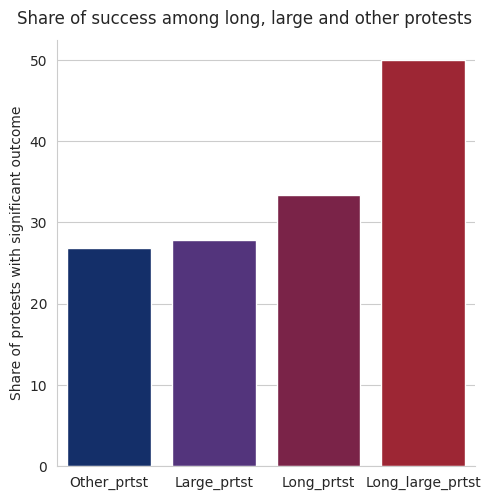

In [35]:
#Define if the duration or strength influence the result
long_protests = (protest[(protest['Long_prtst'] == 1) & (protest['Large_prtst'] == 0)])
large_protests = (protest[(protest['Large_prtst'] == 1) & (protest['Long_prtst'] == 0)])
long_large_protests = (protest[(protest['Large_prtst'] == 1) & (protest['Long_prtst'] == 1)])
other_protests = (protest[(protest['Large_prtst'] == 0) & (protest['Long_prtst'] == 0)])

#Calculate a number of every protest type
n_long_protests = long_protests['Prtst_name'].count()
n_large_protests = large_protests['Prtst_name'].count()
n_long_large_protests = long_large_protests['Prtst_name'].count()
n_other_protests = other_protests['Prtst_name'].count()

#Calculate a number of protests that achieved significant result for every type
long_protests_sig = long_protests.groupby('Sig_outcome').agg({
    'Prtst_name' : 'count'})
long_protests_sig = long_protests_sig.reset_index()
long_protests_sig = long_protests_sig.rename(columns={'Prtst_name':'N_protests'})
long_protests_sig['Share_in_total'] = (long_protests_sig['N_protests']*100 / n_long_protests
                                       ).round(2)
large_protests_sig = large_protests.groupby('Sig_outcome').agg({
    'Prtst_name' : 'count'})
large_protests_sig = large_protests_sig.reset_index()
large_protests_sig = large_protests_sig.rename(columns={'Prtst_name':'N_protests'})
large_protests_sig['Share_in_total'] = (large_protests_sig['N_protests']*100 / n_large_protests
                                       ).round(2)
long_large_protests_sig = long_large_protests.groupby('Sig_outcome').agg(
    {'Prtst_name' : 'count'})
long_large_protests_sig = long_large_protests_sig.reset_index()
long_large_protests_sig = long_large_protests_sig.rename(columns={'Prtst_name':'N_protests'})
long_large_protests_sig['Share_in_total'] = (long_large_protests_sig['N_protests']*100 /
                                             n_long_large_protests).round(2)
other_protests_sig = other_protests.groupby('Sig_outcome').agg({
    'Prtst_name' : 'count'})
other_protests_sig = other_protests_sig.reset_index()
other_protests_sig = other_protests_sig.rename(columns={'Prtst_name':'N_protests'})
other_protests_sig['Share_in_total'] = (other_protests_sig['N_protests']*100 /
                                             n_other_protests).round(2)
protests_sig = pd.concat([long_protests_sig, large_protests_sig, long_large_protests_sig, other_protests_sig],
          keys=['Long_prtst', 'Large_prtst', 'Long_large_prtst', 'Other_prtst'])
print(protests_sig)

# Shorten the resulted table to be used to plot the findings
protests_sig_shrt = protests_sig.reset_index()
protests_sig_shrt = protests_sig_shrt[protests_sig_shrt['Sig_outcome'] == 1]
del protests_sig_shrt['Sig_outcome']
del protests_sig_shrt['level_1']

#Plot
sns.set_palette(['#062A77', '#512888','#891446', '#B11225'])
g = sns.catplot(data=protests_sig_shrt, kind='bar', x='level_0', y='Share_in_total',
            order=['Other_prtst', 'Large_prtst', 'Long_prtst', 'Long_large_prtst'])
g.set(xlabel='', ylabel='Share of protests with significant outcome')
g.fig.suptitle('Share of success among long, large and other protests', y=1.03)
plt.show()

We found that among all the protests occured **'Long and large protests' achieved significant outcome in 50% of cases, 'Long protests'** in **33%** of cases, **'Large protests'** and **'Other protests'** in around **28%** and **27%** of cases **respectevily**.

We will see the share of succeeded protests among these groups is different, checking for statistically significance with 95% confidence level.

In [36]:
# Create column splitting all protest into 4 groups and conduct Chi2 test
prot_long_large = []
for i, v in protest.iterrows():
  if (protest.loc[i, 'Large_prtst'] == 1) & (protest.loc[i,'Long_prtst'] == 0):
    prot_long_large.append('Lar')
  elif (protest.loc[i, 'Large_prtst']==0) & (protest.loc[i, 'Long_prtst']==1): prot_long_large.append('Lon')
  elif (protest.loc[i, 'Large_prtst']==1) & (protest.loc[i, 'Long_prtst']==1): prot_long_large.append('LarLon')
  else: prot_long_large.append('NN')
protest['Long_Large'] = prot_long_large

# Chi2 test
expected, observed, stats = pg.chi2_independence(data=protest, x='Sig_outcome',
                                                y='Long_Large', correction=False)
print(stats)

    

                 test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  7.475813  3.0  0.058183  0.150741  0.621199
1        cressie-read  0.666667  7.289457  3.0  0.063222  0.148850  0.609014
2      log-likelihood  0.000000  6.992134  3.0  0.072149  0.145783  0.589057
3       freeman-tukey -0.500000  6.828049  3.0  0.077585  0.144062  0.577776
4  mod-log-likelihood -1.000000  6.709047  3.0  0.081773  0.142801  0.569478
5              neyman -2.000000  6.592106  3.0  0.086100  0.141551  0.561229


P-value is 0.058 that is a little bit higher than 0.05 so we can´t state with 95% confidence, but we can state with 90% confidence that **persistancy in a protest activity has more influence on final results than quantity of people involved. **  **Protest activity longer than 3 months together with high quantity of protestants (more than 100 000) remarkably increase chances of a protest to achieve a significant result.**

***Covid Influence***

Lets check if covid influenced protest activity in general.
Count the protest group by start date.

2016-10-01 00:00:00
2022-05-01 00:00:00
2038 days 00:00:00


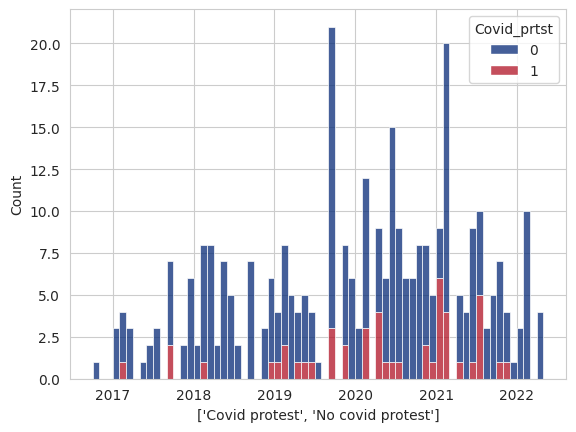

In [38]:
# Group the number of protest by data and covid factor
print(protest['Strt_date'].min())
print(protest['Strt_date'].max())
print(protest['Strt_date'].max() - protest['Strt_date'].min())
sns.set_palette(['#062A77', '#B11225'])
g = sns.histplot(data=protest, x='Strt_date', hue='Covid_prtst', 
                 multiple='stack', bins=67)
g.set(xlabel=['Covid protest', 'No covid protest'])
plt.show()

From the plot we observed higher number of protests burst out from August 2019. We see that **there were some Covid caused protest**, with peaks in March 2020, January and July 2021. However **even not counting for covid protest we observed higher level of protest activity starting from August 2019 and until the beginning of 2022. We can assume that the covid has boosted protest activity mostly by indirect way **disclosing and deepening existing economic estrains and political tensions.

***CONCLUSION***

This report represent an analysis of the Global Protest Tracker dataset related to the world protest activity in a period from September 2016 to March 2022 and the Freedom House 2022 edition dataset on countries freedom scores.

Descriptive analysis conducted allowed to state some limited conclusions about the protest activity in the mentioned period and some general conclusions about protests.

The **main conclusions** are:


*   **High protest activity can be found among countries with any degree of freedom.** In the considered period the top-5 countries by number of protests were: **France, India, United States, Pakistan, Turkey**
*   In the period considered **on average protests erupted in 'Not free' countries slightly more frequently** than in 'Free' and 'Partly free' countries
*   In the period considered **duration of protest had more variation in countries with better freedom status**
*   In the considered period **protest size groups were similarly distributed among countries with different freedom degree. Most of the protests attracted from 1000 to 10 000 protestants**
*   In the considered period **Politics was the most effective trigger**. Top-3 most populated trigger groups were pure Politics, and Politics variation with other triggers
*   In general **violent government response is not depent on country freedom status**
*   In the considered period **the protests that faced violent response from have had higher variation in duration that those that did not face**
*   The governments have a little bit **higher tedency to violent response to the protests that last more than 3 month and involve more than 100 000 protestants**
*   Protest **success is not depent on governent violence and country freedom degree**
*   In general **persistancy in a protest activity has more influence on final results than quantity of people involved.** Protest activity **longer than 3 months** together with **high quantity of protestants (more than 100 000) remarkably increase chances of a protest to achieve a significant result**

*   **Covid has boosted protest activity** but more likely **by indirect way** disclosing and deepening existing economic estrains and political tensions.

